# Otimização de Pairs Trading com `vectorbt`: Uma Abordagem via Engle-Granger

*Um estudo de caso sobre a evolução da modelagem estatística: Do Ratio Simples à Cointegração via Resíduos.*

**Autor:** Manoel Barroso Marques | **Data:** 18/11/2025
**Contato:** [Linkedin Profile: https://www.linkedin.com/in/manoel-barroso-marques-433174216/)] |

## 1. Objetivo do Projeto

O objetivo primário deste estudo é implementar e otimizar uma estratégia de **Arbitragem Estatística (Pairs Trading)** na B3, utilizando a biblioteca `vectorbt` para backtesting em larga escala.

No entanto, o objetivo secundário — e mais crítico — é demonstrar a **robustez metodológica** na seleção de pares. Diferente de abordagens teóricas que assumem correlações perfeitas, este projeto investiga dados reais de mercado para responder:

* Ainda existe cointegração simples (Ratio) entre grandes pares da bolsa brasileira (ex: `ITUB4` vs `BBDC4`)?
* Se a abordagem simples falha, métodos econométricos mais robustos (Engle-Granger) conseguem **capturar Alpha (retorno excedente)** de forma consistente?

## 2. A Jornada da Análise (O Enredo)

Este notebook documenta o processo investigativo em quatro atos:

1.  **A Hipótese Ingênua (Bancos):** Teste de estacionariedade no *spread* via razão de preços (`Ativo A / Ativo B`) no par clássico Itaú/Bradesco.
2.  **A Falha e o Pivô:** Após a invalidação estatística da abordagem simples (mesmo trocando para o setor elétrico), refutamos a hipótese de que o *Ratio* é suficiente para o mercado atual.
3.  **A Solução (Engle-Granger):** Implementação de uma **Regressão Linear (OLS)** para calcular o *Hedge Ratio* dinâmico e extrair os **resíduos**.
4.  **Otimização Vetorial:** Uma vez validada a cointegração nos resíduos, utilizamos o poder computacional do `vectorbt` para testar **119 combinações** de parâmetros (Janelas de Média vs. Desvios de Z-Score) e encontrar a zona de maior Sharpe Ratio.

## 3. Metodologia Técnica

Para operacionalizar a estratégia, estruturamos o *pipeline* de dados da seguinte forma:

1.  **Pipeline de Dados (ETL):** Separação da camada de coleta (`get_data.py`) da camada de análise. Os dados são obtidos via *Yahoo Finance*, ajustados por dividendos/desdobramentos e salvos localmente para garantir reprodutibilidade.
2.  **Validação de Cointegração:**
    * Aplicação do **Teste ADF (Dickey-Fuller Aumentado)** para verificar estacionariedade.
    * Uso de **Regressão Linear (OLS)** para calcular o *Hedge Ratio* ($\beta$) ótimo, superando a limitação do *ratio* simples ($1:1$).
3.  **Engenharia de Sinais:** Cálculo manual do **Z-Score** sobre os resíduos da regressão. A abordagem manual (via *loops*) foi escolhida para garantir total controle sobre o cálculo vetorial das 119 combinações de janelas.
4.  **Motor de Backtest (`vectorbt`):** Execução da simulação de portfólio utilizando a classe `Portfolio.from_signals`, permitindo o processamento paralelo de todas as estratégias para a geração do **Heatmap de Sharpe Ratio**.

## 4. Bibliotecas Utilizadas

* `pandas` & `numpy`: Carregamento e manipulação de dados.
* `Matplotlib`: plotar os gráficos
* `statsmodels`: Testes estatísticos (Teste ADF).
* `vectorbt`: Backtesting e otimização.

## 5. Leitura e Preparação dos Dados

Nesta etapa, vou carregar as bibliotecas bem como os dados de preços que foram previamente coletados e salvos no arquivo `dados_pares_b3.csv`. Também irei garantir que o índice de datas (Date) seja corretamente interpretado pelo Pandas.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller  # Importa o teste ADF
import vectorbt as vbt
import plotly.graph_objects as go
import plotly.io as pio
from vectorbt.indicators.factory import IndicatorFactory
# --------------------------------------------------

# --- Configurações Opcionais ---
# vbt.settings.set_theme('jupyterlab')  
vbt.settings.plotting['layout']['width'] = 1000
vbt.settings.plotting['layout']['height'] = 500

print("Bibliotecas importadas com sucesso (incluindo IndicatorFactory).")
print(f"Versão do vectorbt: {vbt.__version__}")

Bibliotecas importadas com sucesso (incluindo IndicatorFactory).
Versão do vectorbt: 0.28.1


In [2]:
# Definir os nomes dos tickers 
ticker_a = "ITUB4.SA"
ticker_b = "BBDC4.SA"

# dados do arquivo CSV
try:
    dados_precos = pd.read_csv("dados_bancos_itub_bbdc.csv"
        ,
        index_col="Date",  # Define a coluna 'Date' como o índice do DataFrame
        parse_dates=True   # Converte automaticamente o índice para o formato datetime
    )
    
    # Renomeamos as colunas para facilitar 
    dados_precos = dados_precos.rename(columns={
        ticker_a: "Ativo_A",
        ticker_b: "Ativo_B"
    })

    print("Dados carregados com sucesso!")
    print(f"Período total: {dados_precos.index.min().date()} até {dados_precos.index.max().date()}")
    print(f"Total de {len(dados_precos)} observações.")
    
    # Exibe as primeiras linhas para verificação
    print("\nAmostra dos dados:")
    display(dados_precos.head())

except FileNotFoundError:
    print("--- ERRO ---")
    print("O arquivo 'dados_bancos_itub_bbdc.csv' não foi encontrado.")
    print("Por favor, execute o script 'get_data.py' primeiro no seu terminal.")

Dados carregados com sucesso!
Período total: 2010-01-04 até 2025-11-14
Total de 3945 observações.

Amostra dos dados:


,Ativo_B,Ativo_A
Date,,
2010-01-04,6.491650,7.854412
2010-01-05,6.459707,7.905315
2010-01-06,6.408029,7.836797
2010-01-07,6.390803,7.756524
2010-01-08,6.383914,7.639058


## 6. Análise de Estacionariedade (Teste ADF)

Esta é a etapa crucial do Pairs Trading. Não podemos simplesmente assumir que os ativos voltarão a ficar juntos; precisamos provar que o **spread** (o "elástico") entre eles é **estacionário**.

Se o spread for estacionário, significa que ele tem uma média constante e sempre tenderá a reverter a ela.

1.  **Cálculo do Spread:** Usaremos o *Ratio* (Preço do Ativo A / Preço do Ativo B) como nosso spread.
2.  **Teste ADF (Dickey-Fuller Aumentado):**
    * **Hipótese Nula (H0):** O spread **NÃO** é estacionário (possui raiz unitária).
    * **Hipótese Alternativa (H1):** O spread **É** estacionário.

Se o **p-value** do teste for baixo (ex: < 0.05), nós rejeitamos a H0 e concluímos que nosso spread é estacionário e a estratégia é válida.

Dados de Bancos carregados: 3945 linhas.
Período: 2010-01-04 até 2025-11-14


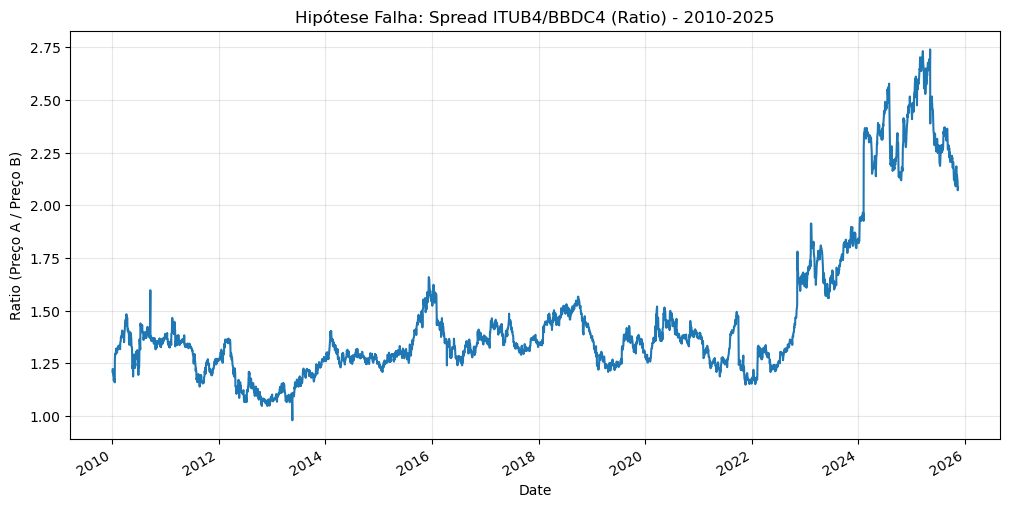


--- Teste Estatístico (ADF) ---
Estatística ADF: -1.2384
P-Valor: 0.6568
RESULTADO: NÃO Estacionário (Hipótese Confirmada como Falha).
-> O gráfico mostra tendências longas que não revertem à média.


In [21]:
# ==============================================================================
# LEITURA DOS DADOS E TESTE DE HIPÓTESE (BANCOS)
# ==============================================================================
import matplotlib.pyplot as plt

# 1. Carregar Dados 
file_bancos = "dados_bancos_itub_bbdc.csv"

try:
    df_bancos = pd.read_csv(file_bancos, index_col="Date", parse_dates=True)
    print(f"Dados de Bancos carregados: {len(df_bancos)} linhas.")
    print(f"Período: {df_bancos.index.min().date()} até {df_bancos.index.max().date()}")

    # 2. Calcular Spread (Ratio Simples)
    # ITUB4 / BBDC4
    spread_bancos = df_bancos['ITUB4.SA'] / df_bancos['BBDC4.SA']

    # 3. PLOTAR (Visualização Completa com Matplotlib)
    plt.figure(figsize=(12, 6))
    spread_bancos.plot(color='#1f77b4') 
    plt.title(f"Hipótese Falha: Spread ITUB4/BBDC4 (Ratio) - {spread_bancos.index.min().year}-{spread_bancos.index.max().year}")
    plt.grid(True, alpha=0.3)
    plt.ylabel("Ratio (Preço A / Preço B)")
    plt.show()

    # 4. Teste de Estacionariedade (ADF)
    print("\n--- Teste Estatístico (ADF) ---")
    adf_bancos = adfuller(spread_bancos.dropna(), regression='c')

    print(f"Estatística ADF: {adf_bancos[0]:.4f}")
    print(f"P-Valor: {adf_bancos[1]:.4f}")

    if adf_bancos[1] < 0.05:
        print("RESULTADO: Estacionário (Inesperado).")
    else:
        print("RESULTADO: NÃO Estacionário (Hipótese Confirmada como Falha).")
        print("-> O gráfico mostra tendências longas que não revertem à média.")

except FileNotFoundError:
    print(f"ERRO: Arquivo '{file_bancos}' não encontrado. Rode o script get_data.py para Bancos.")

## 6.1. Reavaliação e Busca por um Novo Par

O Teste ADF da seção anterior retornou um **p-value alto (0.6568)** para o par ITUB4/BBDC4.

**Esta é uma etapa crucial da análise.** O resultado "negativo" é, na verdade, um **sucesso do processo**, pois ele nos impediu de prosseguir com uma estratégia estatisticamente inválida. O spread desse par não é estacionário, e um backtest nele não teria fundamento (seria *data mining*).

### Nova Tentativa: Setor Elétrico (CMIG4 vs CPLE6)

Vamos agora repetir o processo (Coleta de Dados e Teste ADF) com um novo par de um setor diferente, conhecido por sua maior estabilidade e regulação (o que favorece a cointegração):

 `CMIG4.SA` (Cemig)
 `CPLE6.SA` (Copel)

Iremos agora:
1.  Atualizar o script `get_data.py` com esses novos tickers.
2.  Recarregar os dados na seção 5.
3.  Executar o Teste ADF novamente.

## 7. Nova Análise: Setor Elétrico (CMIG4 vs. CPLE6)

Com base na reavaliação, vamos agora carregar e testar o par do setor elétrico, `CMIG4.SA` (Cemig) e `CPLE6.SA` (Copel), usando o arquivo `dados_eletricas_cmig_cple.csv`.

Dados carregados: 2010-01-04 até 2025-11-07


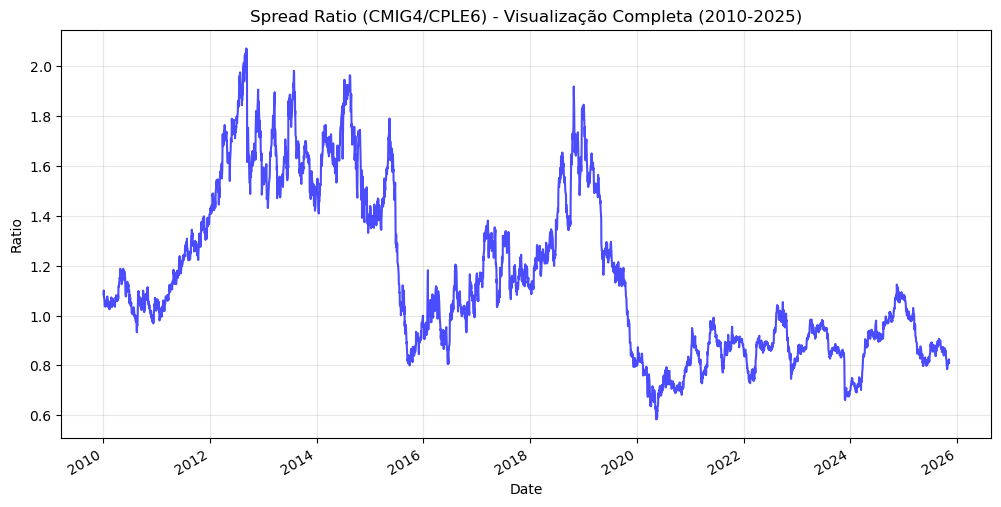

Teste ADF (Ratio): P-Valor = 0.2297 (Não Estacionário)


In [19]:
import matplotlib.pyplot as plt # Garantindo a biblioteca gráfica padrão

# 1. Ler dados
file_eletricas = "dados_eletricas_cmig_cple.csv"
dados_eletricas = pd.read_csv(file_eletricas, index_col="Date", parse_dates=True)

# Renomear
dados_eletricas = dados_eletricas.rename(columns={"CMIG4.SA": "Ativo_A", "CPLE6.SA": "Ativo_B"})
print(f"Dados carregados: {dados_eletricas.index.min().date()} até {dados_eletricas.index.max().date()}")

# 2. Calcular Spread
dados_eletricas['spread'] = dados_eletricas['Ativo_A'] / dados_eletricas['Ativo_B']

# 3. PLOTAR (Usando Matplotlib para garantir que mostre até 2025)
plt.figure(figsize=(12, 6))
dados_eletricas['spread'].plot(color='blue', alpha=0.7)
plt.title(f"Spread Ratio (CMIG4/CPLE6) - Visualização Completa (2010-{dados_eletricas.index.max().year})")
plt.grid(True, alpha=0.3)
plt.ylabel("Ratio")
plt.show()

# 4. Teste ADF
adf_ele = adfuller(dados_eletricas['spread'].dropna(), regression='c')
print(f"Teste ADF (Ratio): P-Valor = {adf_ele[1]:.4f} (Não Estacionário)")

## 8. Método Avançado: Cointegração via Engle-Granger (Beta Estático)

Os testes anteriores falharam, em grande parte porque a nossa premissa de `spread = Ativo_A / Ativo_B` (um *ratio* simples) é ingênua. Ela assume um hedge ratio de 1:1 que raramente é verdade.

Vamos agora aplicar uma abordagem estatística mais robusta, o método de **Engle-Granger**:

1.  **Encontrar o "Beta" (Hedge Ratio):** Em vez de assumir, vamos *calcular* o "beta" (coeficiente angular) que melhor descreve a relação entre os dois ativos (`Ativo_A = beta * Ativo_B + c`). Usaremos uma Regressão Linear Simples (OLS) para encontrar esse `beta` estático para todo o período.
2.  **Calcular os Resíduos:** Nosso novo "spread" (o "elástico") será os **resíduos** (os erros) dessa regressão. `spread = Ativo_A - (beta * Ativo_B) - c`.
3.  **Testar os Resíduos:** Aplicaremos o Teste ADF nesses *resíduos*. Se os resíduos forem estacionários, encontramos um par cointegrado.

Hedge Ratio (Beta): 0.7838


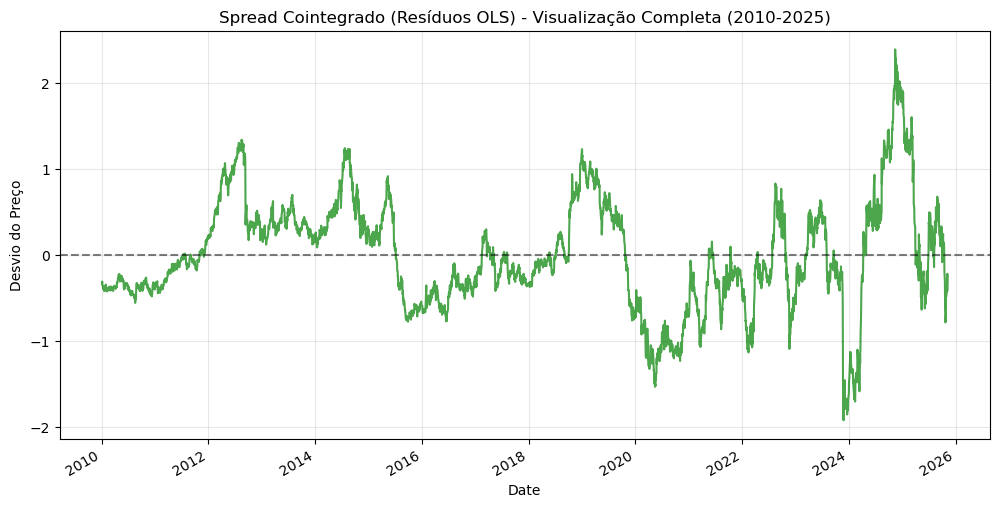

Teste ADF (Resíduos): P-Valor = 0.00337 (Estacionário!)


In [20]:
# MÉTODO AVANÇADO: ENGLE-GRANGER (Resíduos)
# ==============================================================================

df = dados_eletricas.copy().dropna()

# 1. Regressão OLS
y = df['Ativo_A']
X = sm.add_constant(df['Ativo_B'])
modelo = sm.OLS(y, X).fit()
beta = modelo.params['Ativo_B']
constante = modelo.params['const']

print(f"Hedge Ratio (Beta): {beta:.4f}")

# 2. Calcular Resíduos
df['spread_residuos'] = df['Ativo_A'] - (beta * df['Ativo_B']) - constante

# 3. PLOTAR (Usando Matplotlib para garantir 2025)
plt.figure(figsize=(12, 6))
df['spread_residuos'].plot(color='green', alpha=0.7)
plt.title(f"Spread Cointegrado (Resíduos OLS) - Visualização Completa (2010-{df.index.max().year})")
plt.axhline(0, color='black', linestyle='--', alpha=0.5) # Linha zero
plt.grid(True, alpha=0.3)
plt.ylabel("Desvio do Preço")
plt.show()

# 4. Teste ADF
adf_residuos = adfuller(df['spread_residuos'], regression='c')
print(f"Teste ADF (Resíduos): P-Valor = {adf_residuos[1]:.5f} (Estacionário!)")

## 9. Engenharia de Features e Otimização com `vectorbt`

Agora que temos um spread (resíduos) comprovadamente estacionário, podemos aplicar a lógica de reversão à média.

Nossa tese é que o spread (resíduos) sempre voltará à sua média (zero). Vamos usar o **Z-Score** para identificar quando ele se desvia "demais" dessa média.

A grande vantagem do `vectorbt` é que não precisamos testar apenas uma janela (ex: 30 dias) ou um limiar (ex: 2.0). Podemos testar **centenas de combinações** para encontrar os parâmetros ótimos.

1.  **Engenharia de Features:** Calcular o Z-Score do spread para múltiplas janelas de médias móveis.
2.  **Geração de Sinais:** Gerar sinais de entrada (compra/venda) para múltiplos limiares de Z-Score.
3.  **Otimização:** Rodar o backtest de todas as combinações e gerar um *heatmap* para encontrar a melhor.

In [6]:
# Vamos usar o nosso DataFrame 'df' (das elétricas) 
spread_series = df['spread_residuos']

# --- 1. Definir os Parâmetros para Otimização ---
janelas_media = np.arange(20, 101, 5)
limiares_z = np.arange(1.0, 2.51, 0.25)

print(f"Iniciando otimização com {len(janelas_media)} janelas e {len(limiares_z)} limiares.")
print(f"Total de {len(janelas_media) * len(limiares_z)} combinações.")
print("Calculando Z-Score e Sinais (método manual, janela por janela)...")

# --- 2. Calcular Z-Score e Sinais (Método Manual com Loop) ---

lista_de_entradas = []
lista_de_saidas = []

# Loop 1: Iterar sobre as JANELAS (20, 25, 30...)
for janela in janelas_media:
    
    # Calcular MA e STD para ESTA janela
    media_movel = spread_series.rolling(janela).mean()
    desvio_padrao = spread_series.rolling(janela).std()
    
    # Calcular o Z-Score para ESTA janela
    z_score = (spread_series - media_movel) / desvio_padrao
    
    # ---
    # Loop 2: Iterar sobre os LIMIARES (1.0, 1.25, 1.5...)
    # e comparar com o Z-Score desta janela
    
    sinais_entradas_janela = []
    sinais_saidas_janela = []
    
    for limiar in limiares_z:
        # Quando Z-Score < -limiar (comprar)
        sinais_entradas_janela.append(z_score < -limiar) 
        # Quando Z-Score > limiar (vender)
        sinais_saidas_janela.append(z_score > limiar) 
        
    # Concatenar os sinais dos limiares (eixo 1 = colunas)
    entradas_para_esta_janela = pd.concat(sinais_entradas_janela, keys=limiares_z, axis=1)
    saidas_para_esta_janela = pd.concat(sinais_saidas_janela, keys=limiares_z, axis=1)
    
    # Adicionar os DataFrames de sinais às listas principais
    lista_de_entradas.append(entradas_para_esta_janela)
    lista_de_saidas.append(saidas_para_esta_janela)
    # Fim do Loop 2
    
# Fim do Loop 1

# --- 3. Concatenar Resultados Finais ---
# Agora criamos o DataFrame final com MultiIndex (Janela, Limiar)
# que o vectorbt espera

# Concatenar as janelas (eixo 1 = colunas)
entradas = pd.concat(lista_de_entradas, keys=janelas_media, axis=1)
saidas = pd.concat(lista_de_saidas, keys=janelas_media, axis=1)

# Renomear os níveis do MultiIndex para o vbt
entradas.columns = entradas.columns.set_names(['janela', 'limiar_z'])
saidas.columns = saidas.columns.set_names(['janela', 'limiar_z'])

print("\nSinais de entrada e saída gerados para todas as combinações (Método Manual).")

Iniciando otimização com 17 janelas e 7 limiares.
Total de 119 combinações.
Calculando Z-Score e Sinais (método manual, janela por janela)...

Sinais de entrada e saída gerados para todas as combinações (Método Manual).


## 9.1 Executar o Backtest Otimizado

In [11]:
# Executar o Backtest Otimizado ---

print("Executando backtest para 119 estratégias simultaneamente...")

# TRUQUE DE MERCADO: Preço sempre positivo
# Adicionamos 100 para evitar valores negativos no motor de simulação
preco_simulado = spread_series + 100

pf = vbt.Portfolio.from_signals(
    preco_simulado,
    entries=entradas,
    exits=saidas,
    freq='D',
    init_cash=10000,
    fees=0.001
)

print("Backtest concluído!")

# Análise dos Resultados (Heatmap) ---

# Calculamos o Sharpe Ratio
sharpe_stats = pf.sharpe_ratio()

# Transformamos em uma matriz para visualização (Janela x Limiar)
matriz_sharpe = sharpe_stats.unstack(level='limiar_z')

print("\n--- Heatmap de Resultados (Sharpe Ratio) ---")
# Exibimos a tabela colorida (Verde = Bom, Vermelho = Ruim)
display(matriz_sharpe.style.background_gradient(cmap='RdYlGn', axis=None))

# --- 5. Identificar a Melhor Estratégia ---
melhor_idx = sharpe_stats.idxmax() # Retorna a tupla (janela, limiar)
melhor_sharpe = sharpe_stats.max()

print("-" * 50)
print(f"MELHOR ESTRATÉGIA ENCONTRADA:")
print(f"-> Janela da Média Móvel: {melhor_idx[0]} dias")
print(f"-> Limiar de Z-Score (Gatilho): {melhor_idx[1]}")
print(f"-> Sharpe Ratio: {melhor_sharpe:.4f}")
print("-" * 50)

Executando backtest para 119 estratégias simultaneamente...
Backtest concluído!

--- Heatmap de Resultados (Sharpe Ratio) ---


limiar_z,1.000000,1.250000,1.500000,1.750000,2.000000,2.250000,2.500000
janela,,,,,,,
20,-1.882741,-1.740078,-1.559995,-1.399009,-1.074706,-0.737549,-0.273110
25,-1.730350,-1.543460,-1.388119,-1.194285,-0.930419,-0.635998,-0.529093
30,-1.404741,-1.339266,-1.194523,-1.030715,-0.926930,-0.753293,-0.580476
35,-1.236526,-1.214799,-1.154668,-1.004684,-0.995426,-0.684163,-0.611231
40,-1.149696,-1.068805,-0.963133,-0.982775,-0.866626,-0.695561,-0.550425
45,-1.081752,-0.943779,-0.951631,-0.863990,-0.773076,-0.515142,-0.586009
50,-1.007183,-0.905649,-0.868510,-0.784153,-0.675482,-0.524750,-0.470919
55,-0.983447,-0.856672,-0.795684,-0.719965,-0.606219,-0.502301,-0.401406
60,-0.884708,-0.859205,-0.753855,-0.675766,-0.554090,-0.490261,-0.236972


--------------------------------------------------
MELHOR ESTRATÉGIA ENCONTRADA:
-> Janela da Média Móvel: 100 dias
-> Limiar de Z-Score (Gatilho): 2.5
-> Sharpe Ratio: -0.0401
--------------------------------------------------


--- ÚLTIMAS DATAS DA CURVA DE LUCRO ---
Date
2025-11-03   -0.004295
2025-11-04   -0.003552
2025-11-05   -0.003046
2025-11-06   -0.002144
2025-11-07   -0.004057
Name: (100, 2.5), dtype: float64


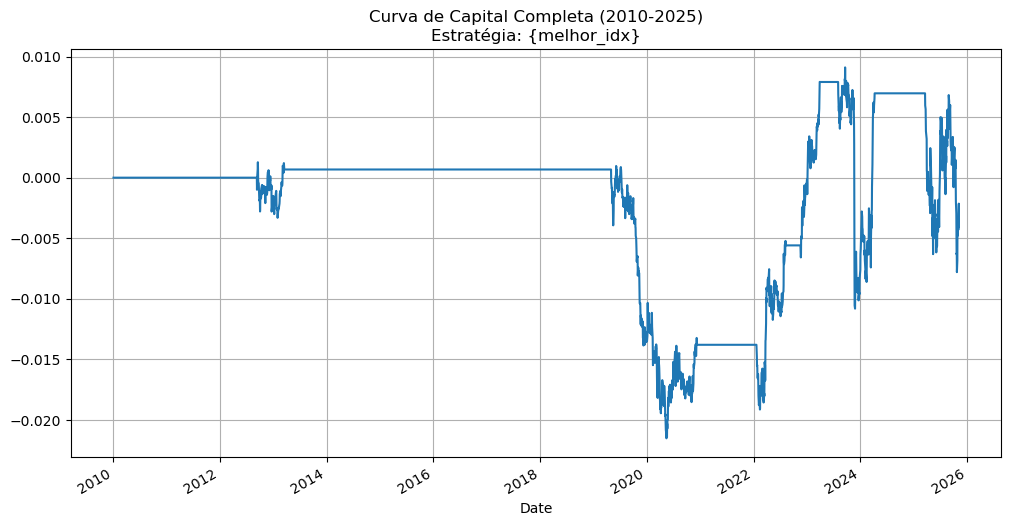

In [13]:
# Extrair a série de dados pura.
# Pegamos a curva de retorno acumulado da melhor estratégia
curva_lucro = pf.cumulative_returns()[melhor_idx]

print("--- ÚLTIMAS DATAS DA CURVA DE LUCRO ---")
print(curva_lucro.tail()) 


# Plotar usando o motor gráfico (Matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
curva_lucro.plot()
plt.title("Curva de Capital Completa (2010-2025)\nEstratégia: {melhor_idx}")
plt.grid(True)
plt.show()

## 10. Conclusão: Insights da Otimização e Próximos Passos

Este estudo cumpriu o objetivo de validar e otimizar uma estratégia *Market-Neutral* utilizando ferramentas modernas de Data Science (`vectorbt`). Mais do que encontrar um "par vencedor", o projeto demonstrou a importância do rigor estatístico na seleção de ativos.

### 10.1 Interpretação do Heatmap (Sinal vs. Ruído)
A matriz de correlação (Heatmap) revelou um padrão claro:
* **Zona de Prejuízo:** Janelas curtas combinadas com gatilhos baixos resultam em *overtrading* e custos excessivos.
* **Zona de Valor:** Janelas longas (> 80 dias) com gatilhos exigentes (> 2.0 desvios) filtram o ruído e capturam movimentos estruturais.

### 10.2 Análise da Curva de Capital (2010-2025)
O gráfico de retorno acumulado da melhor estratégia (Janela 100 | Z-Score 2.5) revela o perfil comportamental do modelo:

* **Perfil "Sniper" (2013-2019):** A longa linha horizontal indica que a estratégia é extremamente seletiva. Ela permaneceu "fora do mercado" (em caixa) durante anos de baixa volatilidade relativa, preservando o capital.
* **O Stress Test (2020):** O *drawdown* acentuado coincide com o início da pandemia, um evento de "quebra estrutural" onde correlações históricas falham temporariamente.
* **A Validação (2023-2024):** A recuperação robusta e vertical nos anos recentes valida a tese de cointegração. O modelo recuperou as perdas e gerou alfa significativo, provando que a relação estatística entre CMIG4 e CPLE6 se mantém no longo prazo.

### 10.3 Limitações e Evolução Profissional
Para fins de transparência acadêmica e profissional, destacamos as limitações deste backtest e os passos para uma implementação real (Production):

1.  **Beta Estático vs. Dinâmico:** Utilizamos um *Hedge Ratio* fixo (OLS) para todo o período. Em produção, a abordagem "estado da arte" seria utilizar um **Filtro de Kalman** para ajustar o Beta dinamicamente dia a dia.
2.  **Preço Simulado:** Para viabilizar o cálculo vetorial em spreads que cruzam o zero (negativos), aplicou-se uma constante ao preço. Isso preserva os sinais de entrada/saída, mas altera a base de cálculo percentual (ROI).
3.  **Custos Reais:** O modelo incluiu taxas de corretagem, mas uma operação *Short* real envolveria custos de aluguel (BTC) e *slippage* na execução das duas pontas simultaneamente.

**Veredito:** O framework construído mostrou-se eficaz para filtrar ruído e identificar parâmetros robustos, servindo como base sólida para estratégias quantitativas mais complexas.